# The PCOS Experience

This is the second part of a project analyzing ***Polycystic Ovarian Syndrome (PCOS)***. This notebook focuses on the experience of those with PCOS, based on the submissions on the PCOS-related Subreddits. 

### Why This Project? 
As per the [Center for Disease Control and Prevention (CDC)](https://www.cdc.gov/diabetes/basics/pcos.html#:~:text=What%20is%20PCOS%3F,beyond%20the%20child%2Dbearing%20years.), Polycystic Ovarian Syndrome (PCOS) affects 6-12% of all reproductive-aged women worldwide, and is one of the most common reasons for infertility. Though it is widely prevalent, it is also extremely under-researched, with no known underlying cause. With this project (as a whole), I aim to get an understanding of the hormonal/physiological aspects of PCOS (notebook 1), as well as get an understanding of the experiences that those with PCOS undego while living with the disorder. 

### Goal (for this notebook)
To find the common topics talked about within the PCOS community, and the general sentiment of those in the community when it comes to PCOS and the posts that they make on Reddit. From a company's perspective, this could give helpful insights into what aspects of PCOS the company should focus on (eg, if the company wants to create an all-in-one medication or supplement for PCOS, they can use the insights from the subreddits analysis to understand the main concerns those with PCOS have, and tune the medication/supplement to handle the main concerns). 

### Data Source
The data is extracted from 8 different subreddits, via Reddit's API (PRAW):
1. **r/PCOS**: Subreddit where those with PCOS (or those who are caring for someone who has PCOS) can ask questions, share experiences, rant, and seek support to deal with the symptoms that come with PCOS.
2. **r/PCOSRECIPES**: Subreddit to share PCOS-friendly recipes
3. **r/PCOSloseit**: Subreddit where those with PCOS can seek help/advice, and share their experience of losing weight, in any way
4. **r/PCOS_CICO**: Subreddit where those who have PCOS can share their experiences and seek advice for using the "calories in, calories out" method of losing weight
5. **r/PCOSandPregnant**: Subreddit where those who have PCOS (and their partners) and are pregnant can share their experiences and seek advice for maintaining a healthy pregnancy. 
6. **r/TTC_PCOS**: Subreddit for those with PCOS who are trying to conceive, and are looking for advice from others who have gone through a similar situation
7. **r/LeanPCOS**: Subreddit for those who have the "Lean" type of PCOS, to ask questions and seek advice about how to maintain their health, tailored to their specific type of PCOS. 
8. **r/PCOS_Folks**: Subreddit for PCOS, emphasizing LGBTQIA+ inclusivity

These subreddits were found by searching for the acronynm "PCOS" on the Reddit website. 

#### Why Reddit? 
Reddit is a free platform for anyone to post what they want, as long as the posters (***Redditors***) abide by the platform's guidelines. The utilization of subreddits allows for organization of topics into their own space, which further allows for data extraction to be an easy task, as long as the Reddit API (***PRAW***) is understood adequately. 

### Skills Used:
* Python (Pandas/NumPy)
* Text Data Cleaning
* Exploratory Data Analysis/Statistical Analysis
* Visualization (using Seaborn, Matplotlib, WordCloud, and Plotly) 
* Feature construction
* Natural Language Processing (Unsupervised Learning, Topic Modeling/Latent Drischlett Allocation/WordCloud)
* API usage/understanding (PRAW)

## Part 1: Data Collection, using the PRAW (Python Reddit API Wrapper) 

In [1]:
import numpy as np 
import pandas as pd 
import praw #reddit api
from pmaw import PushshiftAPI
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from reddit_secrets_praw import secrets #python script containing credentials for the Reddit API 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
reddit = praw.Reddit(client_id = secrets['client_id '],
                     client_secret = secrets['client_secret'],
                     user_agent = secrets['user_agent'])

In [95]:
#Use this code in the data-getting function if you want to get the comments as well: 
sub = reddit.subreddit('PCOS')
h = sub.hot(limit = 3)
# lst = []
# for submission in h: 
#     for comment in submission.comments.list(): 
#         lst.append(comment.body)
# lst

Before I start, I want to see what are the available attributes associated with the subreddit object:

In [88]:
dir(sub)

['MESSAGE_PREFIX',
 'STR_FIELD',
 'VALID_TIME_FILTERS',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_convert_to_fancypants',
 '_create_or_update',
 '_fetch',
 '_fetch_data',
 '_fetch_info',
 '_fetched',
 '_kind',
 '_parse_xml_response',
 '_path',
 '_prepare',
 '_read_and_post_media',
 '_reddit',
 '_reset_attributes',
 '_safely_add_arguments',
 '_submission_class',
 '_submit_media',
 '_subreddit_collections_class',
 '_subreddit_list',
 '_upload_inline_media',
 '_upload_media',
 '_url_parts',
 '_validate_gallery',
 '_validate_inline_media',
 '_validate_time_filter',
 'banned',
 'collections',
 'comments',
 'contributor',
 'controversial',
 'display_n

I will create a function that will extract the data needed when applied to each subreddit. Because PRAW makes it so I cannot explicitly retrieve every single post from each subreddit at once, I will instead get as many posts as possible that are with the tags "hot", "new", "top", and "rising". 

In [4]:
#The below function takes in the reddit object (created above), and the name of the subreddit of interest
def get_subreddit_df(reddit_object_variable, subreddit_name):
    
    subreddit = reddit.subreddit(subreddit_name)
    
    pcos_dict = {"title":[],
                "subreddit":[],
                "score":[], 
                "id":[], 
                "url":[], 
                "comms_num": [], 
                "created": [], 
                "body":[],
                 "flair": [],
                "post_type": []}


    hot_posts = subreddit.hot(limit = 4000)
    new_posts = subreddit.new(limit = 4000)
    top_posts = subreddit.top(limit = 4000)
    rising_posts = subreddit.rising(limit = 4000)
    
    post_types = [hot_posts, new_posts, top_posts, rising_posts]
    
    for post_kind in post_types:
        for submission in post_kind:
            pcos_dict["title"].append(submission.title)
            pcos_dict['subreddit'].append(submission.subreddit)
            pcos_dict["score"].append(submission.score)
            pcos_dict["id"].append(submission.id)
            pcos_dict["url"].append(submission.url)
            pcos_dict["comms_num"].append(submission.num_comments)
            pcos_dict["created"].append(submission.created)
            pcos_dict["body"].append(submission.selftext)
            pcos_dict['flair'].append(submission.link_flair_text)
            pcos_dict['post_type'].append('new')
       
    subreddit_df =  pd.DataFrame(pcos_dict)
    
    return subreddit_df
        

In [5]:
#I will get the subreddit dfs for the pcos-related subreddits, and merge them: 
pcos_df = get_subreddit_df(reddit, 'PCOS')
len(pcos_df)

3018

In [6]:
pcosrecipes_df = get_subreddit_df(reddit, 'PCOSRECIPES')
len(pcosrecipes_df)

280

In [7]:
pcosloseit_df = get_subreddit_df(reddit, 'PCOSloseit')
len(pcosloseit_df)

2988

In [8]:
pcoscico_df = get_subreddit_df(reddit, 'PCOS_CICO')
len(pcoscico_df)

135

In [9]:
pcospregnant_df = get_subreddit_df(reddit, 'PCOSandPregnant')
len(pcospregnant_df)

3022

In [10]:
ttc_df = get_subreddit_df(reddit, 'TTC_PCOS')
len(ttc_df)

3007

In [11]:
lean_df = get_subreddit_df(reddit, 'LeanPCOS')
len(lean_df)

492

In [12]:
folks_df = get_subreddit_df(reddit, 'PCOS_Folks')
len(folks_df)

468

In [13]:
full_df = pd.concat([pcos_df, pcosrecipes_df, pcosloseit_df, pcoscico_df, pcospregnant_df, ttc_df, lean_df, folks_df], axis = 0, ignore_index=True)
len(full_df)


13410

In [14]:
full_df

,title,subreddit,score,id,url,comms_num,created,body,flair,post_type
0,"Daily Rants/Raves/Progress Thread for April 03, 2023",PCOS,1,12au3yf,https://www.reddit.com/r/PCOS/comments/12au3yf/daily_rantsravesprogress_thread_for_april_03_2023/,1,1.680548e+09,"Chat with your friends from r/PCOS here about your daily progress, or rants and raves related to your PCOS experience. Off topic posts are permitted here, although sub rules otherwise apply!",PLEASE ADD FLAIR,new
1,Boils?,PCOS,71,12ao9zo,https://www.reddit.com/r/PCOS/comments/12ao9zo/boils/,58,1.680537e+09,Do you get boils? I haven’t always gotten them but within the last 5 years or so I have. They are usually pretty painful and in or around my lady bits. It is not STD related per my doctor. My grandmother got them before she passed and we suspect she had undiagnosed PCOS.,General Health,new
2,flax seeds and spearmint. if you want to lower your T levels - do not skip out on these two.,PCOS,15,12aw9xw,https://www.reddit.com/r/PCOS/comments/12aw9xw/flax_seeds_and_spearmint_if_you_want_to_lower/,7,1.680553e+09,"when i was first diagnosed with PCOS i browsed this sub on another acc daily and did a shit ton of research. \n\novertime, my obsession with trying to “fix” myself wore off and i kept the info i learned on the back burner. i decided to come back because i used to read success stories over to try and calm myself down that everything would be ok. i want to contribute. \n\n\ni have lean PCOS with androgenic features. th ONLY thing that’s helped me significantly decrease my T was spearmint and flaxseeds. \n\ni used Swanson’s spearmint capsules and ate flax whenev i could. i found flax to be kind of gross so i mainly relied on spearmint tea and capsules. i noticed a major decrease in hirsutism, my face looked softer and more feminine, i even noticed my voice was a lot less hoarse and lowpitch, my periods became more regular and my blood test showed COLD hard proof! unfortunately i don’t remember the numbers, i’ll have to check but even my doctor was surprised and asked me to “keep doing whatever im doing” (he told me it was not possible to decrease my levels). \n\nAnyways i got a little lazy once my supplements ran out and i noticed my hirsutism is slightly back to the way it was. unfortunately i can’t find the supplements on the market these days and i just remembered flax. \n\ni started drinking hot water with 2 tbsp flax mixed in and this is jt far the easiest way i found to consume flax (if you can get past the slimy texture lol…). \n\ni plan to continue drinking spearmint tea and eating flax for the rest of my life. i feel better, i look better and it has also helped take some weight off my shoulders regarding “helplessness”. \n\nhope this helps.",General/Advice,new
3,I never even had PCOS; I’m just fat.,PCOS,37,12aks3w,https://www.reddit.com/r/PCOS/comments/12aks3w/i_never_even_had_pcos_im_just_fat/,12,1.680529e+09,"Long story short: my doctor diagnosed me with PCOS when I told her I hadn’t gotten my period in five months. She told me to lose weight because my BMI is 34, even though I’m super active and eat quite well. \n\nI was on a mission to close all 3 of my Apple Watch rings every day in 2022, so I was already moving / working out a lot. I was also super stressed from work, but she told me I just needed to take better care of myself. I was going to spin classes 4x a week, walking my dog 2-3 miles 5x a week, and weight lifting 2-3 times a week. And she told me I needed to do more… without asking what I was doing in the first place!\n\nAnyway…. All this to say my doctor told me I had PCOS instead of what was CLEARLY Hypothalamic Amenorrhea because of my weight. She said it typically happens to thin people… but guess who’s period came back after a month of rest and eating more?!?!?!\n\nI also went to a gynecologist who refused to listen to my concerns as well and just pushed birth control pills. So frustrating. But I couldn’t understand why none of the PCOS things worke

For future analysis purposes, other potentially helpful features that could be added are tokenized titles, and tokenized bodies. That is, split the titles and bodies into lists of words.  

In [15]:
import string
import nltk
from nltk.corpus import stopwords

def tokenize(text): 
    text = text.lower()
    #first remove any punctuation 
    no_punct = ""
    for char in text:
        if char not in string.punctuation:
            no_punct = no_punct + char
            
    #Now split words into a list 
    string_list = no_punct.split()
    
    stop_words = stopwords.words('english')
    stop_words.extend(['pcos', 'pco', 'pcod', 'pco', "i'm", 'have', 'having', 'me', 'he', 'we', 'she', 'him', 'her',
                      's', 'm', 'i', 'don', 'im', 'dont', 'its', 'discuss'])
    str_list = [word for word in string_list if word not in stop_words]
    return string_list, str_list

In [16]:
full_df['title_tokens'] = full_df['title'].apply(lambda x: tokenize(x)[0])
full_df['title_tokens_no_stopwords'] = full_df['title'].apply(lambda x: tokenize(x)[1])

In [17]:
full_df['body_tokens'] = full_df['body'].apply(lambda x: tokenize(x)[0])
full_df['body_tokens_no_stopwords'] = full_df['body'].apply(lambda x: tokenize(x)[1])

In [18]:
full_df.head(3)

,title,subreddit,score,id,url,comms_num,created,body,flair,post_type,title_tokens,title_tokens_no_stopwords,body_tokens,body_tokens_no_stopwords
0,"Daily Rants/Raves/Progress Thread for April 03, 2023",PCOS,1,12au3yf,https://www.reddit.com/r/PCOS/comments/12au3yf/daily_rantsravesprogress_thread_for_april_03_2023/,1,1.680548e+09,"Chat with your friends from r/PCOS here about your daily progress, or rants and raves related to your PCOS experience. Off topic posts are permitted here, although sub rules otherwise apply!",PLEASE ADD FLAIR,new,"[daily, rantsravesprogress, thread, for, april, 03, 2023]","[daily, rantsravesprogress, thread, april, 03, 2023]","[chat, with, your, friends, from, rpcos, here, about, your, daily, progress, or, rants, and, raves, related, to, your, pcos, experience, off, topic, posts, are, permitted, here, although, sub, rules, otherwise, apply]","[chat, friends, rpcos, daily, progress, rants, raves, related, experience, topic, posts, permitted, although, sub, rules, otherwise, apply]"
1,Boils?,PCOS,71,12ao9zo,https://www.reddit.com/r/PCOS/comments/12ao9zo/boils/,58,1.680537e+09,Do you get boils? I haven’t always gotten them but within the last 5 years or so I have. They are usually pretty painful and in or around my lady bits. It is not STD related per my doctor. My grandmother got them before she passed and we suspect she had undiagnosed PCOS.,General Health,new,[boils],[boils],"[do, you, get, boils, i, haven’t, always, gotten, them, but, within, the, last, 5, years, or, so, i, have, they, are, usually, pretty, painful, and, in, or, around, my, lady, bits, it, is, not, std, related, per, my, doctor, my, grandmother, got, them, before, she, passed, and, we, suspect, she, had, undiagnosed, pcos]","[get, boils, haven’t, always, gotten, within, last, 5, years, usually, pretty, painful, around, lady, bits, std, related, per, doctor, grandmother, got, passed, suspect, undiagnosed]"
2,flax seeds and spearmint. if you want to lower your T levels - do not skip out on these two.,PCOS,15,12aw9xw,https://www.reddit.com/r/PCOS/comments/12aw9xw/flax_seeds_and_spearmint_if_you_want_to_lower/,7,1.680553e+09,"when i was first diagnosed with PCOS i browsed this sub on another acc daily and did a shit ton of research. \n\novertime, my obsession with trying to “fix” myself wore off and i kept the info i learned on the back burner. i decided to come back because i used to read success stories over to try and calm myself down that everything would be ok. i want to contribute. \n\n\ni have lean PCOS with androgenic features. th ONLY thing that’s helped me significantly decrease my T was spearmint and flaxseeds. \n\ni used Swanson’s spearmint capsules and ate flax whenev i could. i found flax to be kind of gross so i mainly relied on spearmint tea and capsules. i noticed a major decrease in hirsutism, my face looked softer and more feminine, i even noticed my voice was a lot less hoarse and lowpitch, my periods became more regular and my blood test showed COLD hard proof! unfortunately i don’t remember the numbers, i’ll have to check but even my doctor was surprised and asked me to “keep doing whatever im doing” (he told me it was not possible to decrease my levels). \n\nAnyways i got a little lazy once my supplements ran out and i noticed my hirsutism is slightly back to the way it was. unfortunately i can’t find the supplements on the market these days and i just remembered flax. \n\ni started drinking hot water with 2 tbsp flax mixed in and this is jt far the easiest way i found to consume flax (if you can get past the slimy texture lol…). \n\ni plan to continue drinking spearmint tea and eating flax for the rest of my life. i feel better, i look better and it has also helped take some weight off my shoulders regarding “helplessness”. \n\nhope this helps.",General/Advice,new,"[flax, seeds, and, spearmint, if, you, want, to, lower, your, t, levels, do, not, skip, out, on, these, two]","[flax, seeds, spearmint, want, lower, lev

In [19]:
#check to see if there are any nulls- I expect there to be nulls in the "flair" feature, because
#some subreddits do not require a flair tag
full_df.isna().sum()

title                           0
subreddit                       0
score                           0
id                              0
url                             0
comms_num                       0
created                         0
body                            0
flair                        7491
post_type                       0
title_tokens                    0
title_tokens_no_stopwords       0
body_tokens                     0
body_tokens_no_stopwords        0
dtype: int64

I was right! Instead of having null values in those entries, I will replace the null values with "No flair" 

In [20]:
full_df['flair'].fillna("no flair", inplace = True)


In [21]:
full_df.isna().sum()

title                        0
subreddit                    0
score                        0
id                           0
url                          0
comms_num                    0
created                      0
body                         0
flair                        0
post_type                    0
title_tokens                 0
title_tokens_no_stopwords    0
body_tokens                  0
body_tokens_no_stopwords     0
dtype: int64

In [22]:
#save to csv: 
full_df.to_csv('all_pcos_subreddits.csv', index = False)

## Part 2: Exploratory Data Analysis

First, I want to see how many submissions we have:

In [23]:
len(full_df)

13410

In [24]:
full_df.dtypes

title                         object
subreddit                     object
score                          int64
id                            object
url                           object
comms_num                      int64
created                      float64
body                          object
flair                         object
post_type                     object
title_tokens                  object
title_tokens_no_stopwords     object
body_tokens                   object
body_tokens_no_stopwords      object
dtype: object

Instead of keeping the 'subreddit' feature values as Subreddit objects, I will convert the values into strings:

In [25]:
full_df['subreddit'] = full_df['subreddit'].apply(lambda x: str(x))

In [26]:
full_df['subreddit'].unique()

array(['PCOS', 'PCOSRECIPES', 'PCOSloseit', 'PCOS_CICO',
       'PCOSandPregnant', 'TTC_PCOS', 'LeanPCOS', 'PCOS_Folks'],
      dtype=object)

In [27]:
len(full_df)

13410

Not a lot of posts for multiple subreddits, but since PCOS is a very specific condition, it is understandable. <br> 

Now, I want to know the average nuumber of words per post. Using the tokenized titles and bodies, I can take the lengths to find them easily. In case I need them later, I will create a new feature in the dataframe containing this information.

In [28]:
#Get the counts, put them in the df as features
full_df['title_count'] = full_df['title_tokens'].apply(lambda x: len(x))
full_df['body_count'] = full_df['body_tokens'].apply(lambda x: len(x))
full_df.head(2)

,title,subreddit,score,id,url,comms_num,created,body,flair,post_type,title_tokens,title_tokens_no_stopwords,body_tokens,body_tokens_no_stopwords,title_count,body_count
0,"Daily Rants/Raves/Progress Thread for April 03, 2023",PCOS,1,12au3yf,https://www.reddit.com/r/PCOS/comments/12au3yf/daily_rantsravesprogress_thread_for_april_03_2023/,1,1.680548e+09,"Chat with your friends from r/PCOS here about your daily progress, or rants and raves related to your PCOS experience. Off topic posts are permitted here, although sub rules otherwise apply!",PLEASE ADD FLAIR,new,"[daily, rantsravesprogress, thread, for, april, 03, 2023]","[daily, rantsravesprogress, thread, april, 03, 2023]","[chat, with, your, friends, from, rpcos, here, about, your, daily, progress, or, rants, and, raves, related, to, your, pcos, experience, off, topic, posts, are, permitted, here, although, sub, rules, otherwise, apply]","[chat, friends, rpcos, daily, progress, rants, raves, related, experience, topic, posts, permitted, although, sub, rules, otherwise, apply]",7,31
1,Boils?,PCOS,71,12ao9zo,https://www.reddit.com/r/PCOS/comments/12ao9zo/boils/,58,1.680537e+09,Do you get boils? I haven’t always gotten them but within the last 5 years or so I have. They are usually pretty painful and in or around my lady bits. It is not STD related per my doctor. My grandmother got them before she passed and we suspect she had undiagnosed PCOS.,General Health,new,[boils],[boils],"[do, you, get, boils, i, haven’t, always, gotten, them, but, within, the, last, 5, years, or, so, i, have, they, are, usually, pretty, painful, and, in, or, around, my, lady, bits, it, is, not, std, related, per, my, doctor, my, grandmother, got, them, before, she, passed, and, we, suspect, she, had, undiagnosed, pcos]","[get, boils, haven’t, always, gotten, within, last, 5, years, usually, pretty, painful, around, lady, bits, std, related, per, doctor, grandmother, got, passed, suspect, undiagnosed]",1,53


For the averages, I will look into the average based on all of the posts, then the averages based on the different subreddits. I will also find the standard deviation

In [29]:
descriptive_stats = {} #going to save everything in a nested dictionary
full_title_avg = round(full_df.loc[:, "title_count"].mean())
full_body_avg = round(full_df.loc[:, "body_count"].mean())
full_title_std = round(full_df.loc[:, "title_count"].std(), 2)
full_body_std = round(full_df.loc[:, "body_count"].std(), 2)
full_title_min = full_df.loc[:, "title_count"].min()
full_title_max = full_df.loc[:, "title_count"].max()
full_bod_min = full_df.loc[:, "body_count"].min()
full_bod_max = full_df.loc[:, "body_count"].max()
descriptive_stats['all_reddits'] = {'title_avg': full_title_avg, 'body_avg': full_body_avg, 
                               'title_std': full_title_std, 'body_std': full_body_std, 'title_min': full_title_min, 
                               'title_max': full_title_max, 'body_min': full_bod_min, 'body_max': full_bod_max}
print(f'Total submissions across all PCOS-related subreddits: {len(full_df)} \n')
print(f'The average word count in all titles is: {str(full_title_avg)}, standard dev: {full_title_std}')
print(f'The average word count in all submission bodies is: {str(full_body_avg)}, standard dev: {full_body_std}')
print(f'Minimum words in title: {full_title_min}, Maximum words in title: {full_title_max}')
print(f'Minimum words in body: {full_bod_min}, Maximum words in title: {full_bod_max} \n')

df_pcos = full_df[full_df['subreddit'] == 'PCOS']
pcos_title_avg= round(df_pcos.loc[:, "title_count"].mean())
pcos_body_avg = round(df_pcos.loc[:, "body_count"].mean())
pcos_title_std = round(df_pcos.loc[:, "title_count"].std(), 2)
pcos_body_std = round(df_pcos.loc[:, "body_count"].std(), 2)
pcos_title_min = df_pcos.loc[:, "title_count"].min()
pcos_title_max = df_pcos.loc[:, "title_count"].max()
pcos_bod_min = df_pcos.loc[:, "body_count"].min()
pcos_bod_max = df_pcos.loc[:, "body_count"].max()
descriptive_stats['PCOS'] = {'title_avg': pcos_title_avg, 'body_avg': pcos_body_avg, 
                               'title_std': pcos_title_std, 'body_std': pcos_body_std, 'title_min': pcos_title_min, 
                               'title_max': full_title_max, 'body_min': pcos_bod_min, 'body_max': pcos_bod_max}
print(f'r/PCOS Total submissions: {len(df_pcos)}')
print(f'The average word count in the r/PCOS submissions titles is: {str(pcos_title_avg)}, standard dev: {pcos_title_std}')
print(f'The average word count in the r/PCOS submissions bodies is: {str(pcos_body_avg)}, standard dev: {pcos_body_std}')
print(f'Minimum words in title: {pcos_title_min}, Maximum words in title: {pcos_title_max}')
print(f'Minimum words in body: {pcos_bod_min}, Maximum words in title: {pcos_bod_max} \n')


df_pcosrecipes = full_df[full_df['subreddit'] == 'PCOSRECIPES']
rec_title_avg = round(df_pcosrecipes.loc[:, "title_count"].mean())
rec_body_avg = round(df_pcosrecipes.loc[:, "body_count"].mean())
rec_title_std = round(df_pcosrecipes.loc[:, "title_count"].std(), 2)
rec_body_std = round(df_pcosrecipes.loc[:, "body_count"].std(), 2)
rec_title_min = df_pcosrecipes.loc[:, "title_count"].min()
rec_title_max = df_pcosrecipes.loc[:, "title_count"].max()
rec_bod_min = df_pcosrecipes.loc[:, "body_count"].min()
rec_bod_max = df_pcosrecipes.loc[:, "body_count"].max()
descriptive_stats['PCOS_Recipes'] = {'title_avg': rec_title_avg, 'body_avg': rec_body_avg, 
                               'title_std': rec_title_std, 'body_std': rec_body_std, 'title_min': rec_title_min, 
                               'title_max': rec_title_max, 'body_min': rec_bod_min, 'body_max': rec_bod_max}
print(f'r/PCOSRECIPES Total submissions: {len(df_pcosrecipes)}')
print(f'The average word count in the r/PCOSRECIPES submissions titles is: {str(rec_title_avg)}, standard dev: {rec_title_std}')
print(f'The average word count in the r/PCOSRECIPES submissions bodies is: {str(rec_body_avg)}, standard dev: {rec_body_std}')
print(f'Minimum words in title: {rec_title_min}, Maximum words in title: {rec_title_max}')
print(f'Minimum words in body: {rec_bod_min}, Maximum words in title: {rec_bod_max} \n')


df_loseit = full_df[full_df['subreddit'] == 'PCOSloseit']
lose_title_avg = round(df_loseit.loc[:, "title_count"].mean())
lose_body_avg = round(df_loseit.loc[:, "body_count"].mean())
lose_title_std = round(df_loseit.loc[:, "title_count"].std(), 2)
lose_body_std = round(df_loseit.loc[:, "body_count"].std(), 2)
lose_title_min = df_loseit.loc[:, "title_count"].min()
lose_title_max = df_loseit.loc[:, "title_count"].max()
lose_bod_min = df_loseit.loc[:, "body_count"].min()
lose_bod_max = df_loseit.loc[:, "body_count"].max()
descriptive_stats['PCOSloseit'] = {'title_avg': lose_title_avg, 'body_avg': lose_body_avg, 
                               'title_std': lose_title_std, 'body_std': lose_body_std, 'title_min': lose_title_min, 
                               'title_max': lose_title_max, 'body_min': lose_bod_min, 'body_max': lose_bod_max}
print(f'r/PCOSloseit Total submissions: {len(df_loseit)}')
print(f'The average word count in the r/PCOSloseit submissions titles is: {str(lose_title_avg)}, standard dev: {lose_title_std}')
print(f'The average word count in the r/PCOSloseit submissions bodies is: {str(lose_body_avg)}, standard dev: {lose_body_std}')
print(f'Minimum words in title: {lose_title_min}, Maximum words in title: {lose_title_max}')
print(f'Minimum words in body: {lose_bod_min}, Maximum words in title: {lose_bod_max} \n')


df_cico = full_df[full_df['subreddit'] == 'PCOS_CICO']
cico_title_avg = round(df_cico.loc[:, "title_count"].mean())
cico_body_avg = round(df_cico.loc[:, "body_count"].mean())
cico_title_std = round(df_cico.loc[:, "title_count"].std(), 2)
cico_body_std = round(df_cico.loc[:, "body_count"].std(), 2)
cico_title_min = df_cico.loc[:, "title_count"].min()
cico_title_max = df_cico.loc[:, "title_count"].max()
cico_bod_min = df_cico.loc[:, "body_count"].min()
cico_bod_max = df_cico.loc[:, "body_count"].max()
descriptive_stats['PCOS_CICO'] = {'title_avg': cico_title_avg, 'body_avg': cico_body_avg, 
                               'title_std': cico_title_std, 'body_std': cico_body_std, 'title_min': cico_title_min, 
                               'title_max': cico_title_max, 'body_min': cico_bod_min, 'body_max': cico_bod_max}

print(f'r/PCOS_CICO Total submissions: {len(df_cico)}')
print(f'The average word count in the r/PCOS_CICO submissions titles is: {str(cico_title_avg)}, standard dev: {cico_title_std}')
print(f'The average word count in the r/PCOS_CICO submissions bodies is: {str(cico_body_avg)}, standard dev: {cico_body_std}')
print(f'Minimum words in title: {cico_title_min}, Maximum words in title: {cico_title_max}')
print(f'Minimum words in body: {cico_bod_min}, Maximum words in title: {cico_bod_max} \n')


df_preg = full_df[full_df['subreddit'] == 'PCOSandPregnant']
preg_title_avg = round(df_preg.loc[:, "title_count"].mean())
preg_body_avg = round(df_preg.loc[:, "body_count"].mean())
preg_title_std = round(df_preg.loc[:, "title_count"].std(), 2)
preg_body_std = round(df_preg.loc[:, "body_count"].std(), 2)
preg_title_min = df_preg.loc[:, "title_count"].min()
preg_title_max = df_preg.loc[:, "title_count"].max()
preg_bod_min = df_preg.loc[:, "body_count"].min()
preg_bod_max = df_preg.loc[:, "body_count"].max()
descriptive_stats['PCOSandPregnant'] = {'title_avg': preg_title_avg, 'body_avg': preg_body_avg, 
                               'title_std': preg_title_std, 'body_std': preg_body_std, 'title_min': preg_title_min, 
                               'title_max': preg_title_max, 'body_min': preg_bod_min, 'body_max': preg_bod_max}

print(f'r/PCOSandPregnant Total submissions: {len(df_preg)}')
print(f'The average word count in the r/PCOSandPregnant submissions titles is: {str(preg_title_avg)}, standard dev: {preg_title_std}')
print(f'The average word count in the r/PCOSandPregnant submissions bodies is: {str(preg_body_avg)}, standard dev: {preg_body_std}')
print(f'Minimum words in title: {preg_title_min}, Maximum words in title: {preg_title_max}')
print(f'Minimum words in body: {preg_bod_min}, Maximum words in title: {preg_bod_max}\n')

df_ttc = full_df[full_df['subreddit'] == 'TTC_PCOS']
ttc_title_avg = round(df_ttc.loc[:, "title_count"].mean())
ttc_body_avg = round(df_ttc.loc[:, "body_count"].mean())
ttc_title_std = round(df_ttc.loc[:, "title_count"].std(), 2)
ttc_body_std = round(df_ttc.loc[:, "body_count"].std(), 2)
ttc_title_min = df_ttc.loc[:, "title_count"].min()
ttc_title_max = df_ttc.loc[:, "title_count"].max()
ttc_bod_min = df_ttc.loc[:, "body_count"].min()
ttc_bod_max = df_ttc.loc[:, "body_count"].max()
descriptive_stats['TTC_PCOS'] = {'title_avg': ttc_title_avg, 'body_avg': ttc_body_avg, 
                               'title_std': ttc_title_std, 'body_std': ttc_body_std, 'title_min': ttc_title_min, 
                               'title_max': ttc_title_max, 'body_min': ttc_bod_min, 'body_max': ttc_bod_max}

print(f'r/TTC_PCOS Total submissions: {len(df_ttc)}')
print(f'The average word count in the r/TTC_PCOS submissions titles is: {str(ttc_title_avg)}, standard dev: {ttc_title_std}')
print(f'The average word count in the r/TTC_PCOS submissions bodies is: {str(ttc_body_avg)}, standard dev: {ttc_body_std}')
print(f'Minimum words in title: {ttc_title_min}, Maximum words in title: {ttc_title_max}')
print(f'Minimum words in body: {ttc_bod_min}, Maximum words in title: {ttc_bod_max}\n')

df_lean = full_df[full_df['subreddit'] == 'LeanPCOS']
lean_title_avg = round(df_lean.loc[:, "title_count"].mean())
lean_body_avg = round(df_lean.loc[:, "body_count"].mean())
lean_title_std = round(df_lean.loc[:, "title_count"].std(), 2)
lean_body_std = round(df_lean.loc[:, "body_count"].std(), 2)
lean_title_min = df_lean.loc[:, "title_count"].min()
lean_title_max = df_lean.loc[:, "title_count"].max()
lean_bod_min = df_lean.loc[:, "body_count"].min()
lean_bod_max = df_lean.loc[:, "body_count"].max()
descriptive_stats['LeanPCOS'] = {'title_avg': lean_title_avg, 'body_avg': lean_body_avg, 
                               'title_std': lean_title_std, 'body_std': lean_body_std, 'title_min': lean_title_min, 
                               'title_max': lean_title_max, 'body_min': lean_bod_min, 'body_max': lean_bod_max}

print(f'r/LeanPCOS Total submissions: {len(df_lean)}')
print(f'The average word count in the r/LeanPCOS submissions titles is: {str(lean_title_avg)}, standard dev: {lean_title_std}')
print(f'The average word count in the r/LeanPCOS submissions bodies is: {str(lean_body_avg)}, standard dev: {lean_body_std}')
print(f'Minimum words in title: {lean_title_min}, Maximum words in title: {lean_title_max}')
print(f'Minimum words in body: {lean_bod_min}, Maximum words in title: {lean_bod_max}\n')

df_folks = full_df[full_df['subreddit'] == 'PCOS_Folks']
folks_title_avg = round(df_folks.loc[:, "title_count"].mean())
folks_body_avg = round(df_folks.loc[:, "body_count"].mean())
folks_title_std = round(df_folks.loc[:, "title_count"].std(), 2)
folks_body_std = round(df_folks.loc[:, "body_count"].std(), 2)
folks_title_min = df_folks.loc[:, "title_count"].min()
folks_title_max = df_folks.loc[:, "title_count"].max()
folks_bod_min = df_folks.loc[:, "body_count"].min()
folks_bod_max = df_folks.loc[:, "body_count"].max()
descriptive_stats['PCOS_Folks'] = {'title_avg': folks_title_avg, 'body_avg': folks_body_avg, 
                               'title_std': folks_title_std, 'body_std': folks_body_std, 'title_min': folks_title_min, 
                               'title_max': folks_title_max, 'body_min': folks_bod_min, 'body_max': folks_bod_max}

print(f'r/PCOS_Folks Total submissions: {len(df_folks)}')
print(f'The average word count in the r/PCOS_Folks submissions titles is: {str(folks_title_avg)}, standard dev: {folks_title_std}')
print(f'The average word count in the r/PCOS_Folks submissions bodies is: {str(folks_body_avg)}, standard dev: {folks_body_std}')
print(f'Minimum words in title: {folks_title_min}, Maximum words in title: {folks_title_max}')
print(f'Minimum words in body: {folks_bod_min}, Maximum words in title: {folks_bod_max}')


Total submissions across all PCOS-related subreddits: 13410 

The average word count in all titles is: 7, standard dev: 6.58
The average word count in all submission bodies is: 118, standard dev: 141.0
Minimum words in title: 1, Maximum words in title: 68
Minimum words in body: 0, Maximum words in title: 2275 

r/PCOS Total submissions: 3018
The average word count in the r/PCOS submissions titles is: 8, standard dev: 6.43
The average word count in the r/PCOS submissions bodies is: 157, standard dev: 170.45
Minimum words in title: 1, Maximum words in title: 60
Minimum words in body: 0, Maximum words in title: 2275 

r/PCOSRECIPES Total submissions: 280
The average word count in the r/PCOSRECIPES submissions titles is: 5, standard dev: 3.69
The average word count in the r/PCOSRECIPES submissions bodies is: 76, standard dev: 98.61
Minimum words in title: 1, Maximum words in title: 16
Minimum words in body: 0, Maximum words in title: 514 

r/PCOSloseit Total submissions: 2988
The average w

**To get a better understanding of what the above means, and for an easier comparison acoss subreddits, I will create box plots**.

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

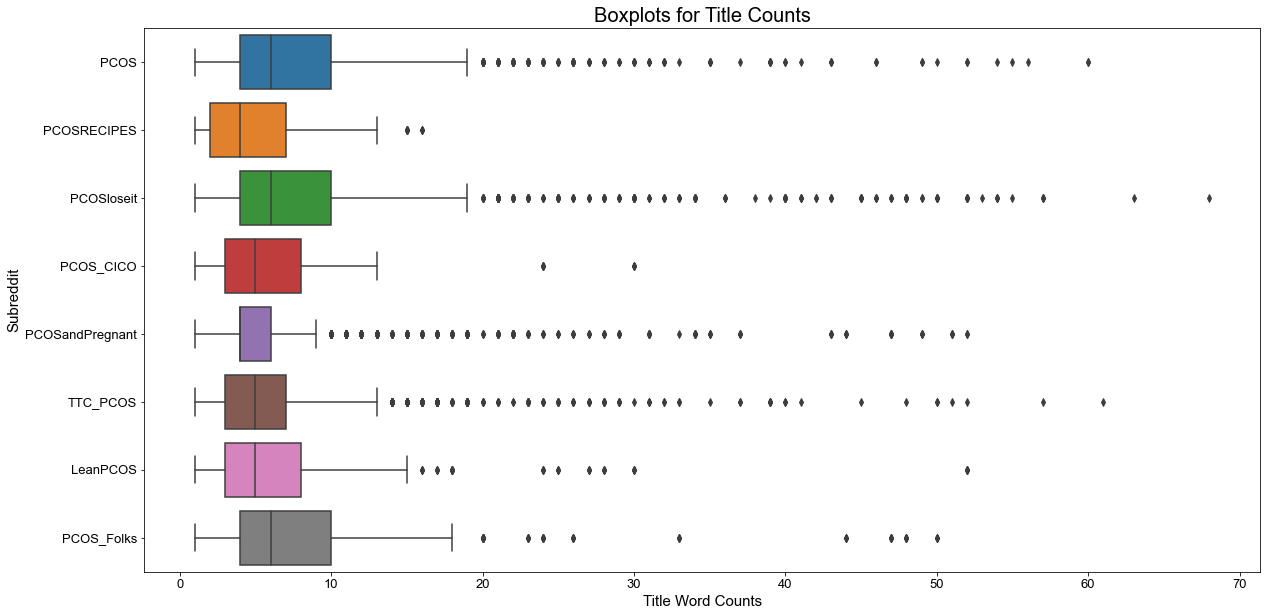

In [31]:
fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("dark")
#First, I will plot the title data:
title_boxplot = sns.boxplot(data= full_df, x= "title_count", y= "subreddit")
title_boxplot.axes.set_title("Boxplots for Title Counts",fontsize= 20)
title_boxplot.set_xlabel("Title Word Counts", fontsize= 15)
title_boxplot.set_ylabel("Subreddit",fontsize= 15)
title_boxplot.tick_params(labelsize=13)

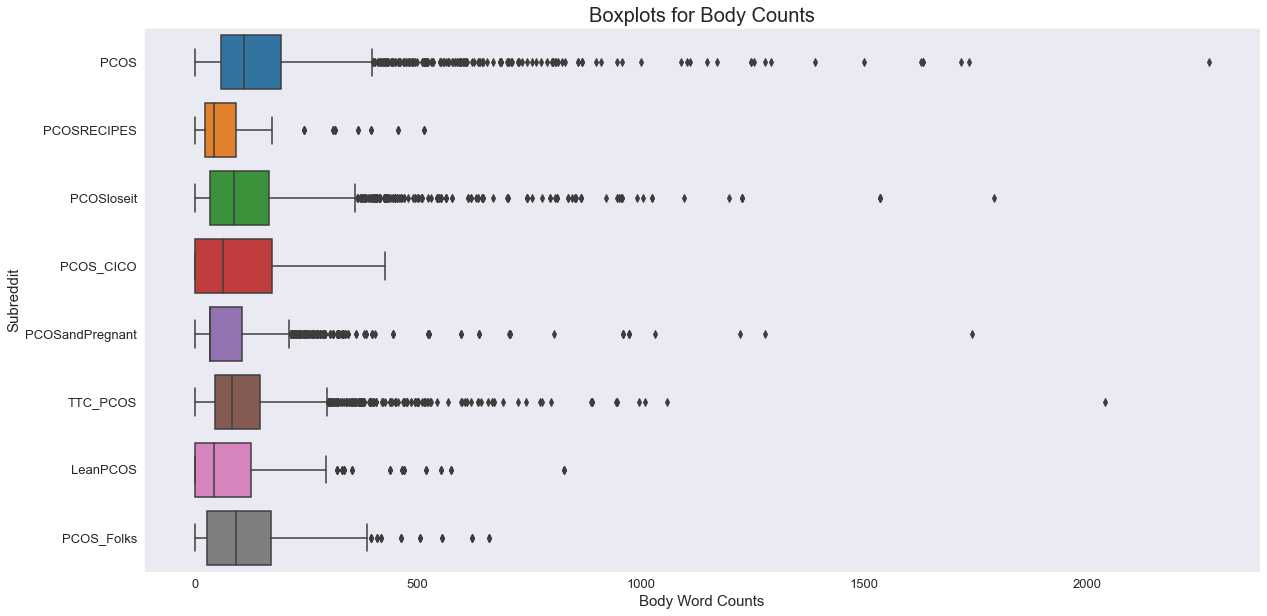

In [32]:
#Now I will plot the body count's data;
fig, ax = plt.subplots(figsize=(20,10))
sns.set_style("dark")
body_boxplot = sns.boxplot(data= full_df, x= "body_count", y= "subreddit")
body_boxplot.axes.set_title("Boxplots for Body Counts",fontsize= 20)
body_boxplot.set_xlabel("Body Word Counts", fontsize= 15)
body_boxplot.set_ylabel("Subreddit",fontsize= 15)
body_boxplot.tick_params(labelsize=13)

#### Boxplots analysis

When it comes to the amount of words used in each submission's bodies, the PCOS subreddit has the largest range of values among all of the subreddits. PCOS_CICO does not have any outliers. Also for PCOS_CICO, as well as LeanPCOS, the minimum values coincide with the lower quartile. PCOS_CICO also has the longest interquartile range, meaning its central range of submission word counts is spread out further. It is important to note that, as shown earlier in the notebook, there is quite a difference between the amount of posts in each subreddit, which gives it a higher chance of there being more outliers in the data, and also have a larger effect on the mean value. Among all of the boxplots, the 3rd and 4th quartiles tend to have wider ranges than those of the 1st and 2nd quartiles (making the boxplots all right/positively skewed)<br> 

When it comes to the titles of the submissions, it seems like the pattern matches that of the bodies'. The one difference I can point out, however, is that the titles all have a minimum count greater than 0, wheras the bodies have minimum values of 0. This is due to Reddit's requirement to have a title in posts, while there is no requirement for a body in a submission. 

I can also look at the descriptive stats in the dataframe form, and do more analysis using it: 

In [33]:
stats_df = pd.DataFrame(descriptive_stats)
stats_df

,all_reddits,PCOS,PCOS_Recipes,PCOSloseit,PCOS_CICO,PCOSandPregnant,TTC_PCOS,LeanPCOS,PCOS_Folks
title_avg,7.00,8.00,5.00,8.00,7.00,6.00,6.00,7.00,9.00
body_avg,118.00,157.00,76.00,128.00,104.00,80.00,114.00,92.00,129.00
title_std,6.58,6.43,3.69,7.93,5.61,5.73,5.43,6.66,8.77
body_std,141.00,170.45,98.61,155.98,119.92,102.97,119.83,130.72,129.71
title_min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
title_max,68.00,68.00,16.00,68.00,30.00,52.00,61.00,52.00,50.00
body_min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
body_max,2275.00,2275.00,514.00,1793.00,426.00,1743.00,2041.00,829.00,659.00


#### Based on the above, how much variance is in the data? 
I can check the variation by using the ***coefficient of variance (CV)***, calculated using the following equation: <br> 
$$
CV = \text{standard deviation} \ / \ \text{mean}
$$

If CV < 1, the variance can be considered low. If CV >= 1, variation can be considered relatively high. 

In [98]:
for column in stats_df.columns: 
    t_avg = stats_df[column].loc['title_avg']
    t_std = stats_df[column].loc['title_std']
    t_cv = round(t_std / t_avg, 2)
    if t_cv >= 1: 
        t_result = 'relatively high variance'
    else: 
        t_result = 'low variance'
    print(f'The CV of the r/{column} submissions titles is {str(t_cv)}. This is {t_result}')
    
    b_avg = stats_df[column].loc['body_avg']
    b_std = stats_df[column].loc['body_std']
    b_cv = round(b_std / b_avg, 2)
    if b_cv >= 1: 
        b_result = 'relatively high variance'
    else: 
        b_result = 'low variance'
    print(f'The CV of the r/{column} submissions bodies is {str(b_cv)}. This is {b_result} \n')
    

The CV of the r/all_reddits submissions titles is 0.94. This is low variance
The CV of the r/all_reddits submissions bodies is 1.19. This is relatively high variance 

The CV of the r/PCOS submissions titles is 0.8. This is low variance
The CV of the r/PCOS submissions bodies is 1.09. This is relatively high variance 

The CV of the r/PCOS_Recipes submissions titles is 0.74. This is low variance
The CV of the r/PCOS_Recipes submissions bodies is 1.3. This is relatively high variance 

The CV of the r/PCOSloseit submissions titles is 0.99. This is low variance
The CV of the r/PCOSloseit submissions bodies is 1.22. This is relatively high variance 

The CV of the r/PCOS_CICO submissions titles is 0.8. This is low variance
The CV of the r/PCOS_CICO submissions bodies is 1.15. This is relatively high variance 

The CV of the r/PCOSandPregnant submissions titles is 0.96. This is low variance
The CV of the r/PCOSandPregnant submissions bodies is 1.29. This is relatively high variance 

The C

#### Variance Analysis: 
Based on the results above, it seems that all of the subreddits have low variance when it comes to their submissions' titles, and have relatively high variance when it comes to the submissions' bodies. This means that, when it comes to the length of the titles, users tend to stay within a small range around the mean amount of words used, while the length of the bodies can vary widely. 

### Flair Analysis
Many subreddits require posters to add **flair** to their posts, which are tags that help with organization of posts. Usually, there are a set of flair tags that the moderators of the subreddits choose.  

In [124]:
#already have the sub-dfs: df_pcos, df_pcosrecipes, df_loseit, df_cico, df_preg, df_ttc, df_lean, df_folks
dfs = [df_pcos, df_pcosrecipes, df_loseit, df_cico, df_preg, df_ttc, df_lean, df_folks]
for df in dfs: 
    name = str(df['subreddit'].unique()[0])
    flair_list = list(df['flair'].unique())
    joined_flairs = ', '.join(flair_list)
    print(f'(Total of: {str(len(flair_list))} flairs)')
    print(f'The unique flairs in r/{name} are: {joined_flairs}\n')
    

(Total of: 26 flairs)
The unique flairs in r/PCOS are: PLEASE ADD FLAIR, General Health, General/Advice, Period, Weight, Mental Health, Rant/Venting, Hirsutism, Meds/Supplements, Diet - Intermittent Fasting, Research/Survey, Success story, Fitness, Diet - Not Keto, Trigger Warning, Inflammation, Fertility, Hair Loss/Thinning, Diet - Keto, Meta, Mod Announcement, no flair, Diet, Rant, Depression/Help, Depression

(Total of: 7 flairs)
The unique flairs in r/PCOSRECIPES are: META, I made something!  , Question/Help, Recipe request, New recipe!, Question, Live event

(Total of: 1 flairs)
The unique flairs in r/PCOSloseit are: no flair

(Total of: 1 flairs)
The unique flairs in r/PCOS_CICO are: no flair

(Total of: 21 flairs)
The unique flairs in r/PCOSandPregnant are: Intro, MOD, no flair, Advice Needed, Other, Happy, Venting, Ultrasound, Sad, Research/Survey, Trigger Warning, Loss, Success Stories, Humor, Daily, Trigger, Positive, Birth Story, Nursery, Bump Photo, Baby Bump

(Total of: 18

**At first look:** It looks like r/PCOSloseit and r/PCOS_CICO do not require flairs when submitting posts,as none of their posts have flair. After looking at the rules for each individual subreddit, it looks like the "no flair" posts in the subreddits that have flair options were likely created before the flair requirements by the moderators. <br> 

How many posts, overall, do not have flair? 

In [35]:
#find the amount of posts among all subs that do not have flair:
no_flair_amount = len(full_df[full_df['flair'] == 'no flair'])
no_flair_amount

7491

What percentage of the total full_df is this?

In [36]:
perc = round((no_flair_amount / len(full_df)) * 100, 2)
print(f'{str(perc)}%')

55.86%


It looks like over 55% of the posts do not have flair! That's quite a bit of posts.

### Sentiment Analysis 
Because these posts are essentially testimonials, another interesting part to look into is the sentiment of each post, through sentiment analysis. I will use TextBlob to find the sentiment of each post, and create a new feature in the dataframe to hold the sentiment polarity, and another feature for subjectivity. <br> 

In terms of polarity, the closer to -1, the more negative sentiment, and the closer to +1, the more positive the sentiment. For subjectivity, the closer to 0, the more objective, and the closer to 1, the more subjective.

In [37]:
from textblob import TextBlob

In [38]:
def sentiment_analysis(text): 
    try:
        txt_blob = TextBlob(text)
        txt_sent = txt_blob.sentiment
        polarity, subjectivity = txt_blob.sentiment 

        return polarity, subjectivity
    except: 
        polarity = np.nan
        subjectivity = np.nan
        return polarity, subjectivity

In [39]:
full_df['title_polarity'] = full_df['title'].apply(lambda x: sentiment_analysis(x)[0])
full_df['title_subjectivity'] = full_df['title'].apply(lambda x: sentiment_analysis(x)[1])

In [40]:
full_df['body_polarity'] = full_df['body'].apply(lambda x: sentiment_analysis(x)[0])
full_df['body_subjectivity'] = full_df['body'].apply(lambda x: sentiment_analysis(x)[1])

In [41]:
full_df[['title','body', 'title_polarity', 'title_subjectivity','body_polarity', 'body_subjectivity']].tail(10)

,title,body,title_polarity,title_subjectivity,body_polarity,body_subjectivity
13400,Does anyone have advice or information about dealing with PCOS while being genderqueer?,"i got my diagnosis years ago, in highschool. i’m now 19. i’ve been identifying as non-binary/gender-fluid for years as well, and since i got the diagnosis i’ve been worried that the physical symptoms that actually help my dysphoria (facial hair, a deeper voice) might go away if i treat the PCOS in a way that will be effective. \ni’ve been on metformin for awhile now, and recently got a higher dose with a new doctor who (thankfully) is very kind and listens to me much more than the other one did. i’m seeing her tomorrow. the metformin helps alleviate the severe depression and chronic fatigue, but my periods are still awful. I’ve been bleeding for 60 days as of today. \n\nwill a hysterectomy help (i’m assuming not since PCOS is more than a uterine problem)? will HRT help? do i need to try birth control? am i going to have to spend hundreds on solutions that won’t work? do i only feel like i’m not cis due to the hormonal imbalances caused by PCOS?\n\ni’m just incredibly lost 😖 I don’t want to trade symptom relief for mental turmoil due to dysphoria. i also feel incredibly unqualified to talk or ask about these things, especially considering the lack of research done on PCOS in the first place. \n\nthank you to anyone who took the time to read this and/or respond. i appreciate you!",0.000000,0.000000,0.170193,0.535287
13401,Strongly considering quitting birth control,"To preface this, I'm a nonbinary afab minor who has to take birth control for hormonal imbalance reasons. I had a lot of concerns going in about getting a more ""feminine"" body shape and larger cup size. It's been almost two months of taking the pills and I've had a few dysphoric episodes because I thought my chest was looking more noticeable. The only solution I can see is to just stop taking them. I cannot tell my parents about my concerns or the dysphoria to get another appointment because I think they already suspect Im trans. If I tell them these things, itll outright confirm for them. The only issue with this plan is a followup appointment I have in may. I might have to lie...I feel like this desition of mine is stupid and dangerous, but I dont want to deal with chest dysphoria anymore. I'd like to know the risks of what I'm going to do. Maybe it'll talk me out of this.",0.433333,0.733333,-0.072222,0.633333
13402,Ok so I’ll ask my question here: Do you consider PCOS to be an intersex condition? Why or why not?,Personally I don’t know if it technically is but I personally don’t identify as intersex and I’m a very femme cis woman who goes by she/her pronouns.,0.500000,0.500000,0.050000,0.250000
13403,Just diagnosed,"Hi everyone, I was just diagnosed with PCOS along with being anemic and insulin resistant. I may also have endometriosis and my doctor said I am showing signs of uterine cancer. They’re unable to do a cancer test and endometrial biopsy for another two weeks. My doctor put me on metformin. She made it seem like I’m unable to eat anything but salad and that if I eat anything else I will get sick. Is this true? What can I truly expect from metformin? I’m feeling overwhelmed and hopeless. I already struggle with treatment resistant bipolar depression and severe anxiety&panic attacks. This diagnosis and the lack of answers and waiting for tests is making me a wreck. I just want to be able to be pain free and enjoy my life.",0.000000,0.000000,-0.009184,0.633163
13404,Do You Consider PCOS A Disability?,"I'm just genuinely curious if anyone here considers pcos a disability. I've seen arguments for both sides (mainly the not side).\n\nthe fact the not disability side seems to be the common consensus is shocking to me. I mean the chronic pain and fatigue can be unbearable at times and hinders daily life. How is that not a disability? \n\nand yes i know it's legally not one but we ain't talk

I will look at the distribution of the polarities and subjectivities:

Text(0.5, 1.0, 'Body Subjectivity Distribution')

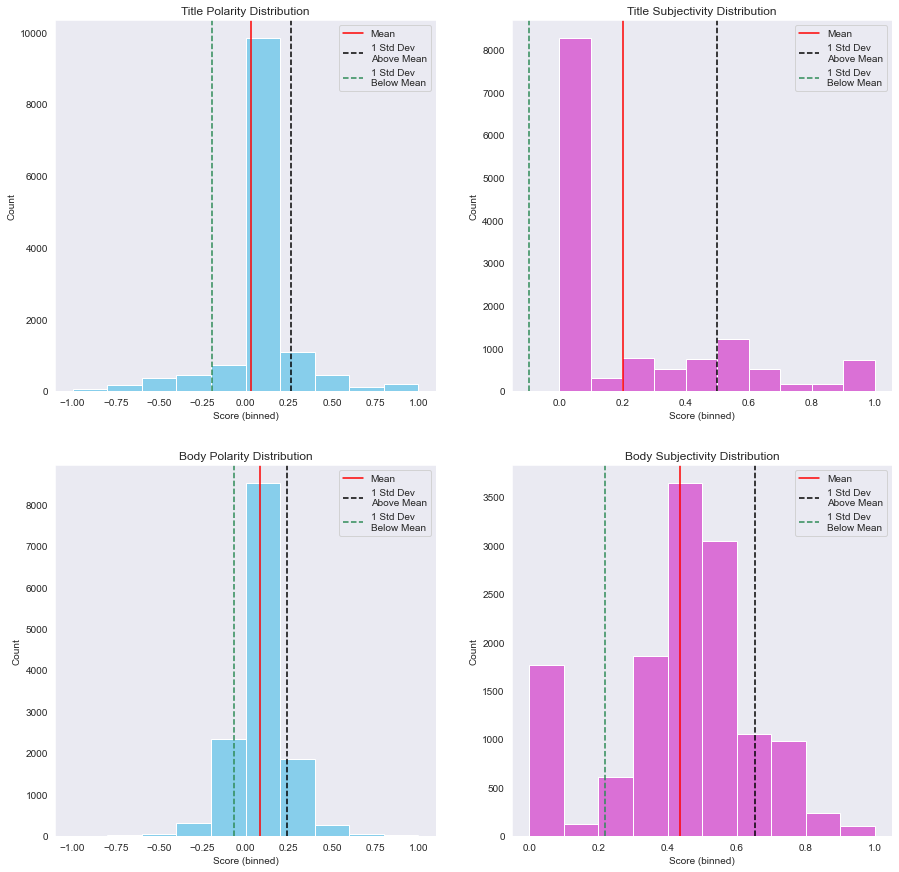

In [42]:
fig, axs = plt.subplots(2, 2, figsize = (15,15))
axs[0,0].hist(full_df['title_polarity'], color = 'skyblue')
axs[0,0].axvline(x = full_df['title_polarity'].mean(), color = 'r', label = 'Mean')
axs[0,0].axvline(x = full_df['title_polarity'].mean() + full_df['title_polarity'].std(), color = 'black', linestyle = '--', label = '1 Std Dev \nAbove Mean')
axs[0,0].axvline(x = full_df['title_polarity'].mean() - full_df['title_polarity'].std(), color = 'seagreen', linestyle = '--', label = '1 Std Dev \nBelow Mean')
axs[0,0].set(xlabel='Score (binned)', ylabel='Count')
axs[0,0].legend(fancybox = True)
axs[0,0].set_title('Title Polarity Distribution')

axs[0,1].hist(full_df['title_subjectivity'], color = 'orchid')
axs[0,1].axvline(x = full_df['title_subjectivity'].mean(), color = 'r', label = 'Mean')
axs[0,1].axvline(x = full_df['title_subjectivity'].mean() + full_df['title_subjectivity'].std(), color = 'black', linestyle = '--', label = '1 Std Dev \nAbove Mean')
axs[0,1].axvline(x = full_df['title_subjectivity'].mean() - full_df['title_subjectivity'].std(), color = 'seagreen', linestyle = '--', label = '1 Std Dev \nBelow Mean')
axs[0,1].set(xlabel='Score (binned)', ylabel='Count')
axs[0,1].legend()
axs[0,1].set_title('Title Subjectivity Distribution')

axs[1,0].hist(full_df['body_polarity'], color = 'skyblue')
axs[1,0].axvline(x = full_df['body_polarity'].mean(), color = 'r', label = 'Mean')
axs[1,0].axvline(x = full_df['body_polarity'].mean() + full_df['body_polarity'].std(), color = 'black', linestyle = '--', label = '1 Std Dev \nAbove Mean')
axs[1,0].axvline(x = full_df['body_polarity'].mean() - full_df['body_polarity'].std(), color = 'seagreen', linestyle = '--', label = '1 Std Dev \nBelow Mean')
axs[1,0].set(xlabel='Score (binned)', ylabel='Count')
axs[1,0].legend()
axs[1,0].set_title('Body Polarity Distribution')

axs[1,1].hist(full_df['body_subjectivity'], color = 'orchid')
axs[1,1].axvline(x = full_df['body_subjectivity'].mean(), color = 'r', label = 'Mean')
axs[1,1].axvline(x = full_df['body_subjectivity'].mean() + full_df['body_subjectivity'].std(), color = 'black', linestyle = '--', label = '1 Std Dev \nAbove Mean')
axs[1,1].axvline(x = full_df['body_subjectivity'].mean() - full_df['body_subjectivity'].std(), color = 'seagreen', linestyle = '--', label = '1 Std Dev \nBelow Mean')
axs[1,1].set(xlabel='Score (binned)', ylabel='Count')
axs[1,1].legend()
axs[1,1].set_title('Body Subjectivity Distribution')



**Analysis**: <br> 
To reiterate, in terms of polarity, the closer to -1, the more negative sentiment, and the closer to +1, the more positive the sentiment. For subjectivity, the closer to 0, the more objective, and the closer to 1, the more subjective. <br> 

In terms of ***polarity***, it looks as if both the titles and the bodies are about normally distributed. For the titles, the polarities are overwhelmingly situated in the 0-0.25 bin, showing generally-neutral polarity. This also has influenced the mean polarity to be just over 0. The same can be said for the polarities of the bodies of the submissions, though there is a bit more values binned in the -0.25 - 0 bins and 0.25-0.5 bins. This is likely why the mean is a bit more than that of the titles' mean. <br> 

While the polarities for both titles and bodies show similar sentiment distributions, this cannot be said about the ***subjectivity*** between the two text types. For the titles, it looks like the majority of titles are objective, skewing right. For the bodies, there is an almost-normal distribution in subjectivity, with a slight bias towards being subjective, and about 1750 submission bodies being clearly subjective (subjectivity score between 0 and 0.1). The differences between the titles' and bodies' distributions may demonstrate that the users may want to create titles that are generally objective, and then add in their subjectivity when going into detail in the body of their post(s). 

## Part 3: Topic Modeling
Now that I have a general idea of the sentiments of the Reddit posts, I now want to know: ***what*** are the common topics that are talked about in these posts? To do this, I will utilize Latent Drischlett Allocation (LDA) to do topic modeling (unsupervised learning method).

***Based on Part 1's notebook and the Kaggle dataset used, I suspect that the topics will be related to the hormones that were featured, along with weight and ovulation.*** 

In [8]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from wordcloud import WordCloud

For topic modeling, I will be using Latent Drischlett Allocation (LDA). <br> 

**What is LDA?** <br> 
LDA is a form of matrix factorization, much like Principal Component Analysis (PCA). It assumes that the documents in the corpus are a mixture of topics, and the topics are a mixture of words (or ***tokens***). LDA works by decomposing the large corpus document-word matrix, into two smaller matrices: the document-topic matrix, and the topic-word matrix. <br> 
The original document-word matrix is essentially set as a dataset with all the words found in the documents (after preprocessing) as features, and each word represents a single document. The values in the matrix represent how many times a particular word features is present within a particular document. <br> 


In [44]:
def find_topic(input_text, random_seed = 42): 
    #Wrap the code in a try/except block, in case a value is empty
    try:
        stop_words = stopwords.words('english') #using nltk's stopwords, since it has more than gensim's stopwords list
        
        #The stopwords are limited, so after some testing, below are some extra stopwords that show up 
        #as topics but are not necessarily actual topics
        #I am also removing 'pcos', because it is already obvious that the posts will be 
        #related to PCOS, since they are posted on the PCOS-related subreddits:
        stop_words.extend(['pcos','to', 'more', 'of', 'have', 'may', 'dont', 'd', 'm', 've', 'thing', 
                          'things', 'take', 'taken', 'taking', 'force', 'forcing', 'notice', 'noticed', 
                          'noticing', 'very', 'feel', 'feeling', 'regularly', 'regular', 'welcome', 
                          'especially', 'thanks', 'share', 'knew', 'weeks', 'days', 'months', 'know', 
                          'understand', 'lot', 'want', 'unfortunately', 'unfortunate', 'week',
                          'day', 'month', 'year', 'years', 'go', 'going', 'quick', 'quickly', 'main',
                          'mainly', 'up', 'down', 'side', 'want', 'wanting', 'need', 'help', 
                          'helped', 'got', 'despite', 'hanging', 'tell', 'show', 'early', 'late', 'time',
                          'typical', 'typically', 'experience', 'experienced', 'far', 'follow', 'follows', 'wind', 
                          'out', 'newly', 'new', 'test', 'think', 'bother', 'come', 'include', 'post', 
                          'would', 'wouldn', "it's", "don", "don't", "ve", 's', 'ed', 't', 'like', 'try', 'trying', 
                          'tries', 'tried', 'else', 'other', 'otherwise', 'etc', 'except', 'everyone', 'sub', 
                          'depth', 'anyone', 'yesterday', 'today', 'tomorrow', 'title', 'consistent', 'lo', 
                          'hi', 'tri', 'also', 'maybe', 'really', 'been', "i'm", 'already', 'like',
                          'ive', 'time', 'find', 'way', 'make', 'er', 'opk', 'say', 'make'])
        paragraph = input_text
        preprocessed_paragraph = [word for word in simple_preprocess(paragraph) if word not in stop_words]

        # Create a dictionary of words in the paragraph
        word_dict = Dictionary([preprocessed_paragraph])

        # Create a corpus of the paragraph
        corpus = [word_dict.doc2bow([word]) for word in preprocessed_paragraph]

        # Train a topic model on the corpus
        lda_model = LdaModel(corpus=corpus, id2word=word_dict, num_topics=1, random_state = random_seed)

        # Extract the top 3 words for the topic from the model
        topic = lda_model.show_topics(num_topics= 1, num_words= 9, formatted=False)[0][1]
        
        return [word[0] for word in topic][0], [word[0] for word in topic][1] #returns the first 2 topics
        
    except: #If there is no value to apply this function to, instead of having an error pop up, do:
        topic = 'No text to find topic'
        return topic, topic


Before applying the function to the entire dataframe, I will first do tests on a randomly chosen inputs, one test input from the body festure, and one from the title feature. This will give me insight on whether or not the function gives me some sort of input (ie, it doesn't give me an error), and I can see if there are any output topics that should be included in the list of stopwords used to pre-process the text in the function. 

In [45]:
full_df['body'].loc[12999]

"Hello everyone! I hope you're all doing well!\n\nI posted about this back when I was still running the survey a few months ago, and a few people said they'd be interested in seeing the results. For more context, see the post linked below:\n\n[https://www.reddit.com/r/PCOS\\_Folks/comments/n39nfh/pcos\\_gender\\_survey\\_casual\\_survey/?utm\\_source=share&utm\\_medium=web2x&context=3](https://www.reddit.com/r/PCOS_Folks/comments/n39nfh/pcos_gender_survey_casual_survey/?utm_source=share&utm_medium=web2x&context=3)\n\nWell, I'm happy to announce that I've finally finished analyzing the data! I wanted to share it here because, like I said before, some people expressed interest in seeing the results. I also thought it would just be the kind of thing people on this subreddit might like to see!\n\n[Here's the link to the post on my tumblr, which links to the results doc! \\[LINK\\]](https://pcos-and-gender-survey.tumblr.com/post/660892278452289536/pcos-survey-2021-results)\n\n*TW/CW for the

In [46]:
#test out the function before applying it:
find_topic(full_df['body'].loc[12999])

('results', 'survey')

In [47]:
full_df['title'].loc[1510]

'PCOS, no period & hyperinsulinemia.. scared I will get T2 diabetes.'

In [48]:
find_topic(full_df['title'].loc[1510])

('diabetes', 'get')

In [49]:
#since topics tend to be shorter, I will only take the first topic of the title
full_df['title_topic'] = full_df['title'].apply(lambda x: find_topic(x)[0]) 

In [50]:
full_df['body_topic_1'] = full_df['body'].apply(lambda x: find_topic(x)[0])
full_df['body_topic_2'] = full_df['body'].apply(lambda x: find_topic(x)[1])

In [51]:
full_df.head()

,title,subreddit,score,id,url,comms_num,created,body,flair,post_type,title_tokens,title_tokens_no_stopwords,body_tokens,body_tokens_no_stopwords,title_count,body_count,title_polarity,title_subjectivity,body_polarity,body_subjectivity,title_topic,body_topic_1,body_topic_2
0,"Daily Rants/Raves/Progress Thread for April 03, 2023",PCOS,1,12au3yf,https://www.reddit.com/r/PCOS/comments/12au3yf/daily_rantsravesprogress_thread_for_april_03_2023/,1,1.680548e+09,"Chat with your friends from r/PCOS here about your daily progress, or rants and raves related to your PCOS experience. Off topic posts are permitted here, although sub rules otherwise apply!",PLEASE ADD FLAIR,new,"[daily, rantsravesprogress, thread, for, april, 03, 2023]","[daily, rantsravesprogress, thread, april, 03, 2023]","[chat, with, your, friends, from, rpcos, here, about, your, daily, progress, or, rants, and, raves, related, to, your, pcos, experience, off, topic, posts, are, permitted, here, although, sub, rules, otherwise, apply]","[chat, friends, rpcos, daily, progress, rants, raves, related, experience, topic, posts, permitted, although, sub, rules, otherwise, apply]",7,31,0.00,0.0,0.000000,0.200000,raves,topic,friends
1,Boils?,PCOS,71,12ao9zo,https://www.reddit.com/r/PCOS/comments/12ao9zo/boils/,58,1.680537e+09,Do you get boils? I haven’t always gotten them but within the last 5 years or so I have. They are usually pretty painful and in or around my lady bits. It is not STD related per my doctor. My grandmother got them before she passed and we suspect she had undiagnosed PCOS.,General Health,new,[boils],[boils],"[do, you, get, boils, i, haven’t, always, gotten, them, but, within, the, last, 5, years, or, so, i, have, they, are, usually, pretty, painful, and, in, or, around, my, lady, bits, it, is, not, std, related, per, my, doctor, my, grandmother, got, them, before, she, passed, and, we, suspect, she, had, undiagnosed, pcos]","[get, boils, haven’t, always, gotten, within, last, 5, years, usually, pretty, painful, around, lady, bits, std, related, per, doctor, grandmother, got, passed, suspect, undiagnosed]",1,53,0.00,0.0,-0.112500,0.591667,No text to find topic,doctor,per
2,flax seeds and spearmint. if you want to lower your T levels - do not skip out on these two.,PCOS,15,12aw9xw,https://www.reddit.com/r/PCOS/comments/12aw9xw/flax_seeds_and_spearmint_if_you_want_to_lower/,7,1.680553e+09,"when i was first diagnosed with PCOS i browsed this sub on another acc daily and did a shit ton of research. \n\novertime, my obsession with trying to “fix” myself wore off and i kept the info i learned on the back burner. i decided to come back because i used to read success stories over to try and calm myself down that everything would be ok. i want to contribute. \n\n\ni have lean PCOS with androgenic features. th ONLY thing that’s helped me significantly decrease my T was spearmint and flaxseeds. \n\ni used Swanson’s spearmint capsules and ate flax whenev i could. i found flax to be kind of gross so i mainly relied on spearmint tea and capsules. i noticed a major decrease in hirsutism, my face looked softer and more feminine, i even noticed my voice was a lot less hoarse and lowpitch, my periods became more regular and my blood test showed COLD hard proof! unfortunately i don’t remember the numbers, i’ll have to check but even my doctor was surprised and asked me to “keep doing whatever im doing” (he told me it was not possible to decrease my levels). \n\nAnyways i got a little lazy once my supplements ran out and i noticed my hirsutism is slightly back to the way it was. unfortunately i can’t find the supplements on the market these days and i just remembered flax. \n\ni started drinking hot water with 2 tbsp flax mixed in and this is jt far the easiest way i found to consume flax (if you can get past the slimy texture lol…). \n\ni plan to continue drinking spearmint tea and eating flax for the rest of my life. i feel better, i look better and it has also helped take some

How many unique first topics are there? 

In [4]:
len(full_df['body_topic_1'].unique())

1394

The second topics?

In [5]:
len(full_df['body_topic_2'].unique())

1666

Title topics?

In [6]:
len(full_df['title_topic'].unique())

1849

It looks like there are some topics that match in each feature, given the amount of unique values are less than the total length of the data frame. Let's see if any of the unique first and second topics of the bodies align: 

In [6]:
first_topics = list(full_df['body_topic_1'].unique())
second_topics = list(full_df['body_topic_2'].unique()) 

topics_intersection = list(set(first_topics) & set(second_topics))
len(topics_intersection)

781

It looks like 781 of the 2000+ unique topics betwwen the two features are the same. 

Since I have the data I need in full_df, I will pickle the dataframe so that I can come back to it without having to run the entire notebook again

In [125]:
#full_df.to_pickle('pcos_reddit_df.pkl')

In [2]:
#To load the dataframe from the pickle file, uncomment the following line: 

full_df = pd.read_pickle('pcos_reddit_df.pkl')

In [3]:
full_df.head()

,title,subreddit,score,id,url,comms_num,created,body,flair,post_type,title_tokens,title_tokens_no_stopwords,body_tokens,body_tokens_no_stopwords,title_count,body_count,title_polarity,title_subjectivity,body_polarity,body_subjectivity,title_topic,body_topic_1,body_topic_2
0,"Daily Rants/Raves/Progress Thread for April 03, 2023",PCOS,1,12au3yf,https://www.reddit.com/r/PCOS/comments/12au3yf/daily_rantsravesprogress_thread_for_april_03_2023/,1,1.680548e+09,"Chat with your friends from r/PCOS here about your daily progress, or rants and raves related to your PCOS experience. Off topic posts are permitted here, although sub rules otherwise apply!",PLEASE ADD FLAIR,new,"[daily, rantsravesprogress, thread, for, april, 03, 2023]","[daily, rantsravesprogress, thread, april, 03, 2023]","[chat, with, your, friends, from, rpcos, here, about, your, daily, progress, or, rants, and, raves, related, to, your, pcos, experience, off, topic, posts, are, permitted, here, although, sub, rules, otherwise, apply]","[chat, friends, rpcos, daily, progress, rants, raves, related, experience, topic, posts, permitted, although, sub, rules, otherwise, apply]",7,31,0.00,0.0,0.000000,0.200000,raves,topic,friends
1,Boils?,PCOS,71,12ao9zo,https://www.reddit.com/r/PCOS/comments/12ao9zo/boils/,58,1.680537e+09,Do you get boils? I haven’t always gotten them but within the last 5 years or so I have. They are usually pretty painful and in or around my lady bits. It is not STD related per my doctor. My grandmother got them before she passed and we suspect she had undiagnosed PCOS.,General Health,new,[boils],[boils],"[do, you, get, boils, i, haven’t, always, gotten, them, but, within, the, last, 5, years, or, so, i, have, they, are, usually, pretty, painful, and, in, or, around, my, lady, bits, it, is, not, std, related, per, my, doctor, my, grandmother, got, them, before, she, passed, and, we, suspect, she, had, undiagnosed, pcos]","[get, boils, haven’t, always, gotten, within, last, 5, years, usually, pretty, painful, around, lady, bits, std, related, per, doctor, grandmother, got, passed, suspect, undiagnosed]",1,53,0.00,0.0,-0.112500,0.591667,No text to find topic,doctor,per
2,flax seeds and spearmint. if you want to lower your T levels - do not skip out on these two.,PCOS,15,12aw9xw,https://www.reddit.com/r/PCOS/comments/12aw9xw/flax_seeds_and_spearmint_if_you_want_to_lower/,7,1.680553e+09,"when i was first diagnosed with PCOS i browsed this sub on another acc daily and did a shit ton of research. \n\novertime, my obsession with trying to “fix” myself wore off and i kept the info i learned on the back burner. i decided to come back because i used to read success stories over to try and calm myself down that everything would be ok. i want to contribute. \n\n\ni have lean PCOS with androgenic features. th ONLY thing that’s helped me significantly decrease my T was spearmint and flaxseeds. \n\ni used Swanson’s spearmint capsules and ate flax whenev i could. i found flax to be kind of gross so i mainly relied on spearmint tea and capsules. i noticed a major decrease in hirsutism, my face looked softer and more feminine, i even noticed my voice was a lot less hoarse and lowpitch, my periods became more regular and my blood test showed COLD hard proof! unfortunately i don’t remember the numbers, i’ll have to check but even my doctor was surprised and asked me to “keep doing whatever im doing” (he told me it was not possible to decrease my levels). \n\nAnyways i got a little lazy once my supplements ran out and i noticed my hirsutism is slightly back to the way it was. unfortunately i can’t find the supplements on the market these days and i just remembered flax. \n\ni started drinking hot water with 2 tbsp flax mixed in and this is jt far the easiest way i found to consume flax (if you can get past the slimy texture lol…). \n\ni plan to continue drinking spearmint tea and eating flax for the rest of my life. i feel better, i look better and it has also helped take some

### Evaluating the LDA Model
Because I am using topic modeling to look into the semantics of the Reddit posts, there are two ways I can go about evaluating how my model did at assigning topics: <br> 
1. **Human Judgment**, using visualization methods. WordClouds are a common visualization tool for this. This also allows us to see if there were any potential stopwords that were missed during pre-processing, allowing us to go back and add it to the stopwords list. <br> 
2. **Quantitative Metrics**, using perplexity (finding the log-likelihood of a held-out subset of the corpus) or coherence (calculating the conditional likelihood of co-occurrence). 

#### Human Judgement: WordClouds
To get a better look at what the topics are, I will create two WordClouds: one for the body (containing topics from both relevant features), and one for the title topics. For each, I will look at the top 50 words (topics). WordClouds are a visualized cluster of words from a corpus, depicting the key words. The larger and bolder the word, the more it is used within the text corpus. 

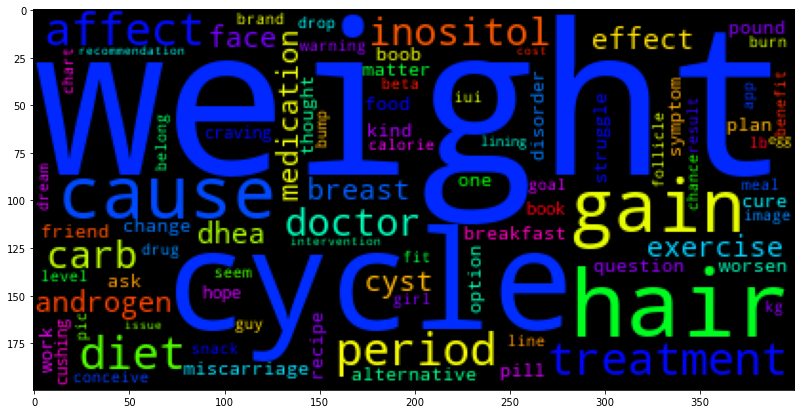

In [4]:
wc1 = WordCloud(
    #background_color='white',
    colormap = 'gist_rainbow',
    max_words = 85, 
    random_state = 42,
    max_font_size=110
    )

wc1.generate(' '.join(full_df['title_topic'].unique())) #want all the values to be in one juge string
plt.figure(figsize=(40,7))
plt.imshow(wc1)
plt.show()




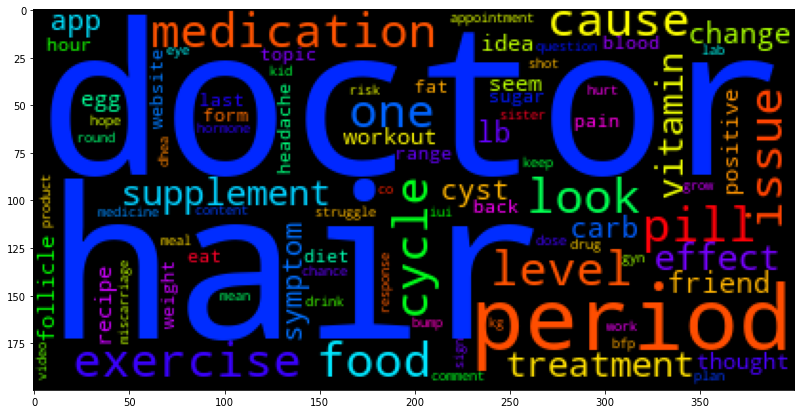

In [7]:
wc = WordCloud(
    #background_color='white',
    colormap = 'gist_rainbow',
    max_words = 85, 
    random_state = 42,
    max_font_size=110
    )

#join the two unique topics lists from each body feature together: 
unique_topics = first_topics + second_topics  
wc.generate(' '.join(unique_topics)) #want all the values to be in one huge string
plt.figure(figsize=(40,7))
plt.imshow(wc)
plt.show()

It looks like the main topics of the post have to deal with the overall health of the individual Redditors, from areas ranging from hormonal health to physical health. More about this will be discussed in the "Discussion/Conclusion" section.

The above looks at topics based on only one word. __What about common phrases (*n-grams*)__? For this, I will use Gensim's Phrases to find the most common phases (in this case, bigrams). 

In [116]:
#before finding the n-grams, I want to remove the stopwords and punctuation 

def remove_stopwords_and_punct(input_text):
    stop_words = stopwords.words('english') #using nltk's stopwords, since it has more than gensim's stopwords list
        
    #The stopwords are limited, so after some testing, below are some extra stopwords that show up 
    #as topics but are not necessarily actual topics
    #I am also removing 'pcos', because it is already obvious that the posts will be 
    #related to PCOS, since they are posted on the PCOS-related subreddits:
    stop_words.extend(['pcos','to', 'more', 'of', 'have', 'may', 'dont', 'd', 'm', 've', 'thing', 
                      'things', 'take', 'taken', 'taking', 'force', 'forcing', 'notice', 'noticed', 
                      'noticing', 'very', 'feel', 'feeling', 'regularly', 'regular', 'welcome', 
                      'especially', 'thanks', 'share', 'knew', 'weeks', 'days', 'months', 'know', 
                      'understand', 'lot', 'want', 'unfortunately', 'unfortunate', 'week',
                      'day', 'month', 'year', 'years', 'go', 'going', 'quick', 'quickly', 'main',
                      'mainly', 'up', 'down', 'side', 'want', 'wanting', 'need', 'help', 
                      'helped', 'got', 'despite', 'hanging', 'tell', 'show', 'early', 'late', 'time',
                      'typical', 'typically', 'experience', 'experienced', 'far', 'follow', 'follows', 'wind', 
                      'out', 'newly', 'new', 'test', 'think', 'bother', 'come', 'include', 'post', 
                      'would', 'wouldn', "it's", "don", "don't", "ve", 's', 'ed', 't', 'like', 'try', 'trying', 
                      'tries', 'tried', 'else', 'other', 'otherwise', 'etc', 'except', 'everyone', 'sub', 
                      'depth', 'anyone', 'yesterday', 'today', 'tomorrow', 'title', 'consistent', 'lo', 
                      'hi', 'tri', 'also', 'maybe', 'really', 'been', "i'm", 'already', 'like',
                      'ive', 'time', 'find', 'way', 'make', 'er', 'opk', 'say', 'make', 'free', 'discuss', 'whatever',
                      'us', 'let', 'reddit', 'www', 'com', 'along', 'chat', 'sure', 'rules', 'even', 'though',
                      'daily', 'came', 'back'])
    paragraph = input_text
    preprocessed_paragraph = [word for word in simple_preprocess(paragraph) if word not in stop_words]
    new_text = ' '.join(preprocessed_paragraph)
    return new_text



In [117]:
from sklearn.feature_extraction.text import CountVectorizer

full_df['preprocessed_body_joined'] = full_df['body'].apply(lambda x: remove_stopwords_and_punct(x))

body_preprocessed = full_df['preprocessed_body_joined'].to_list()
c_vec = CountVectorizer(ngram_range=(2, 2))

# input to fit_transform() should be an iterable with strings
ngrams = c_vec.fit_transform(body_preprocessed)

# needs to happen after fit_transform()
vocab = c_vec.vocabulary_

count_values = ngrams.toarray().sum(axis=0)

n_grams_list = [(ng_count, ng_text) for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)]
# output n-grams
# for ng_count, ng_text in sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True):
#     print(ng_count, ng_text)

n_grams_list[:5] #just to see if it worked

[(1456, 'lose weight'),
 (1287, 'birth control'),
 (1118, 'weight loss'),
 (865, 'crazy symptoms'),
 (861, 'symptoms cravings')]

In [118]:
#how many bigrams are there? 
len(n_grams_list)

236592

There are a lot of n_grams! Let's look at the distribution of the amounts to get an idea of where I should keep the focus: 

In [119]:
n_grams = [tup[1] for tup in n_grams_list]
counts = [tup[0] for tup in n_grams_list]

n_grams_dict = {n_grams[i]: counts[i] for i in range(len(n_grams))}

ngrams_ser = pd.Series(n_grams_dict)

ngrams_df = ngrams_ser.to_frame().reset_index()

ngrams_df = ngrams_df.rename(columns= {0: 'counts', 'index': 'bigrams'})

ngrams_df.head(10)

,bigrams,counts
0,lose weight,1456
1,birth control,1287
2,weight loss,1118
3,crazy symptoms,865
4,symptoms cravings,861
5,insulin resistance,743
6,low carb,697
7,get pregnant,635
8,losing weight,470
9,weight gain,455


In [120]:
ngrams_df.tail(10)

,bigrams,counts
236582,aah anyway,1
236583,aafp org,1
236584,aafed ddcd,1
236585,aace guidelines,1
236586,aace disease,1
236587,aaah exciting,1
236588,aaaand tiny,1
236589,aaaahhhhhh never,1
236590,aa tenor,1
236591,aa however,1


I suspect there will be a large amount of the bigrams will only have low counts. 

In [121]:
#the amount of ngrams with counts less than or equal to 100
len(ngrams_df[ngrams_df['counts'] <= 100])

236504

In [122]:
#the amount of ngrams with counts greater than 100
len(ngrams_df[ngrams_df['counts'] > 100])

88

Out of all of the bigrams, only 88 unique bigrams have been mentioned over 100 times. This is a large cut down from the overall total of 236592! I will use these bigrams to find the more significant phrases/topics talked about in the subreddits. 

In [123]:
relevant_bigrams = ngrams_df[ngrams_df['counts'] > 100]

In [124]:
import plotly.express as px

chart = px.bar(relevant_bigrams, x = 'bigrams', y = 'counts', color = 'counts', 
               title = 'Bigrams with Counts > 100')

chart.show()

It appears that there are several counts that are between 100 and 200. Because of this, but how many exactly?

In [125]:
len(relevant_bigrams[relevant_bigrams['counts'] < 200])

63

63 of the 90 bigrams have counts between 100 and 200. Because there are counts that are significantly larger (800+), I will further decrease the bigrams included for analysis:

In [126]:
relevant_bigrams = relevant_bigrams[relevant_bigrams['counts'] >= 200]

In [128]:
chart = px.bar(relevant_bigrams, x = 'bigrams', y = 'counts', color = 'counts', 
               title = 'Most Common Topics (Bigrams with Counts >= 200)')

chart.update_layout(showlegend=False)
chart.show()

**Note that the above bigrams are a result of multiple trials with stopwords, and multiple iterations of adding stopwords** <br>

From the above topics, I gather that, much like the topics found through the word clouds, there are a few main topics that are widely talked about within the PCOS community, including: ***weight (including weight loss and gaining weright), insulin resistance, mestruation, hair, and pregnancy***. More about this will be discussed in the "Discussion/Conclusion" section. 

#### Quantitative Metric: Coherence
While Gensim's LDA model works well with individual paragraphs (like how we applied it to each individual submission), coherence models generally work best when working with an entire corpus, like all of the values pertaining to a particular feature. To do this, I will look at all of the titles and bodies at the same time, performing LDA and finding the coherence score. 

Below is the function I will use to generate the coherence score:<br> 

#### EDIT: After running coherence model, I keep receiving nan values for coherence (for both umass and c_v). After searching for the issue through the documentation and through others' experiences (on StackOverflow), it may be a Numpy or Gensim version problem that has not been resolved. 

In [120]:

# def find_coherence(input_text, original_series_list, topic_amount = 9, random_seed = 42): 
#     #Wrap the code in a try/except block, in case a value is empty
#     #try:
#     stop_words = stopwords.words('english') #using nltk's stopwords, since it has more than gensim's stopwords list

#     #The stopwords are limited, so after some testing, below are some extra stopwords that show up 
#     #as topics but are not necessarily actual topics
#     #I am also removing 'pcos', because it is already obvious that the posts will be 
#     #related to PCOS, since they are posted on the PCOS-related subreddits:
#     stop_words.extend(['pcos','to', 'more', 'of', 'have', 'may', 'dont', 'd', 'm', 've', 'thing', 
#                       'things', 'take', 'taken', 'taking', 'force', 'forcing', 'notice', 'noticed', 
#                       'noticing', 'very', 'feel', 'feeling', 'regularly', 'regular', 'welcome', 
#                       'especially', 'thanks', 'share', 'knew', 'weeks', 'days', 'months', 'know', 
#                       'understand', 'lot', 'want', 'unfortunately', 'unfortunate', 'week',
#                       'day', 'month', 'year', 'years', 'go', 'going', 'quick', 'quickly', 'main',
#                       'mainly', 'up', 'down', 'side', 'want', 'wanting', 'need', 'help', 
#                       'helped', 'got', 'despite', 'hanging', 'tell', 'show', 'early', 'late', 'time',
#                       'typical', 'typically', 'experience', 'experienced', 'far', 'follow', 'follows', 'wind', 
#                       'out', 'newly', 'new', 'test', 'think', 'bother', 'come', 'include', 'post', 
#                       'would', 'wouldn', "it's", "don", "don't", "ve", 's', 'ed', 't', 'like', 'try', 'trying', 
#                       'tries', 'tried', 'else', 'other', 'otherwise', 'etc', 'except', 'everyone', 'sub', 
#                       'depth', 'anyone', 'yesterday', 'today', 'tomorrow', 'title', 'consistent', 'lo', 
#                       'hi', 'tri', 'also', 'maybe', 'really', 'been', "i'm", 'already', 'like',
#                       'ive', 'time', 'find', 'way', 'make', 'er', 'opk', 'say'])
#     paragraph = input_text
#     preprocessed_paragraph = [word for word in simple_preprocess(paragraph) if word not in stop_words]

#     # Create a dictionary of words in the paragraph
#     word_dict = Dictionary([preprocessed_paragraph])

#     # Create a corpus of the paragraph
#     corpus = [word_dict.doc2bow([word]) for word in preprocessed_paragraph]

#     # Train a topic model on the corpus
#     lda_model = LdaModel(corpus=corpus, id2word=word_dict, num_topics= topic_amount, random_state = random_seed)
#     #um_cm = CoherenceModel(model= lda_model, corpus= corpus, coherence='u_mass')
#     cv_cm = CoherenceModel(model= lda_model,dictionary = word_dict, texts=original_series_list, coherence = 'c_v')
#     #um_coherence_score = round(um_cm.get_coherence(), 3)  # get coherence value
#     cv_coherence_score = round(cv_cm.get_coherence(), 3)
#     return cv_coherence_score #um_coherence_score
        
# #     except: #If there is no value to apply this function to, instead of having an error pop up, do:
# #         cv_coherence_score = np.nan#um_coherence_score = np.nan #np.nan because there's no text to find coherence/do LDA with. 
# #         return cv_coherence_score#um_coherence_score

In [122]:
# copy_df = full_df.copy()

# #get the two separate corpuses, one for title and one for body
# body_ser = copy_df[copy_df['body'] != '']['body'] #get the bodies that are not empty
# body_list = body_ser.to_list()
# body_join = ' '.join(body_list) #get the list into one long, single paragraph so that I can pass it through the above

# #do the same as above for the titles: 
# title_ser = copy_df[copy_df['title'] != '']['title']
# title_list = title_ser.to_list()
# title_join = ' '.join(title_list)

In [123]:
# body_coherence = find_coherence(body_join, body_list)
# body_coherence 

## Part 4: Discussion/Conclusion
To go back to the question of "what do those with PCOS tend to talk about the most with their fellow "***cysters***" (a common term that is used among those with PCOS to add a sense of community, though note it may not be considered inclusive of all bodies experiencing the disorder)?", it seems that my suspicion was partly correct: ***a large portion of topics covered in the subreddit submissions are related to weight and ovulation.*** This can be seen through the WordClouds and bigrams created earlier. However, there are a few interesting points that I did not suspect: <br> 
* **Appearance:** along with weight, it seems that many posters in the subreddits of interest are concerned about their hair and facial appearance. <br>
    * ***Why this makes sense:*** [At least 75% of those with PCOS have insulin resistance.](https://journals.sagepub.com/doi/pdf/10.2217/WHE.14.73) The excess insulin levels can cause the ovaries to over-produce testosterone. These heightened androgen levels can lead to **hirsutism**, excess female body and facial hair. Excess androgens in females can also cause **male-pattern baldness**. Generally, westernized society has been conditioned to believe that those who identify as female must have feminine features, including little-to-no facial hair. This standard set by westernized standards can cause mental and emotional distress to those who do not fit the norms, thus causing them to find ways to change in order to fit those standards (and increase the confidence that may have been diminished). These appearance-related topics (as well as a few other negatively-connotationed "topics"/"words" menationed, like "struggle") make me believe that the subredditors are trying to find suggestions to help change their features, by looking to others who may have successfully been able to do so. 
* **Supplements/Vitamins and Medication:** Based on the WordClouds, it looks like several posters are talking about potential supplements and medications that can be taken, possibly to alleviate PCOS symptoms. The most-mentioned of these is ***inositol***
    * ***Why this makes sense:*** With the lack of information about PCOS, many of those with PCOS are suggested to take medications that are used for different illnesses/disorders (e.g, metformin, which is usually for type II diabetes). Many are also suggested to take more "natural" supplements for various reasone, such as their insurance not covering the prescription medications, or if thy are trying to avoid prescribed drugs and prefer more natural approaches. Inositol is one of the most researched supplements for PCOS, and has been shown to [increase insulin sensitivity in those with PCOS, and decrease testosterone levels](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5655679/). The significant amount of posts with inositol as their topic could be the Redditors inquiring about potential dosage, safety, and potential reactions that others have experienced.
    
If a company wanted to look into a potential all-in-one supplenent to handle PCOS symptoms, it may be worth looking into the above concerns found through topic modeling, and then look into supplements that have already been researched for these symptoms, like inositol (finding that inositol is widely talked about in the community has given the idea to look into other potential supplements). After searching, the following are some other supplements that are taken, and why they have been shown to be successful in treating PCOS symptoms. <br> 
* **Berberine:** Berberine is a [yellow-colored chemical found in a few variety of plants](https://www.webmd.com/vitamins/ai/ingredientmono-1126/berberine), such as the European barberry, goldenseal, and Oregon grape. In [a clincial study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8890747/) comparing the effects of berberine, metformin, and myo-inositol in those with PCOS, berberine has been found to show more potential to reduce cardiovascular disease risk than in PCOS, as the group that was administered berberine showed greater improvement in their clinical, hormonal, and lipid profiles. Based on this finding, Berberine would be able to assits in many of the concerns shown through the topics found in Part 3 of this notebook, including: weightloss, blood glucose levels, and cycle regulation. 
* **Spearmint:** Spearmint, a specific species of mint, has been shown to have [anti-androgenic effects](https://pubmed.ncbi.nlm.nih.gov/17310494/), with the ability to treat mild cases of hirsutism. 
* **Magnesium:** People with PCOS tend to be more likely to have lower levels of magnesium than those who do not have PCOS. Magnesium plays an [important role in glucose metabolism](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0058278#:~:text=Magnesium%20has%20been%20proposed%20to,type%202%20diabetes%20%5B28%5D.), through its interaction with tyrosine-kinase activity on the insulin receptor. The lack of magnesium can negatively influence glucose metabolism, leading to lessened insulin sensitivity/heightened insulin resistance. Taking magnesium supplements can assist in increasing insulin sensitivity/decreasing insulin resistance.
* **Omega-3s:** Popular sources of Omega-3s include fish (and fish oil), algae oil, and flaxseed (and flaxseed oil). Omega 3s have the potential to [decrease the cardiovascular disease risks](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5461594/) in those with PCOS, who tend to have heightened LDL (low-density lipoprotein). 
* **N-Acetyl Cysteine (NAC):** Cysteine is one of the amino acids found in the human body, which act as the building blocks for protein. NAC is the common supplement form, which is then converted into cysteine when consumed. NAC acts as a powerful antioxidant, and have been found to [decrease fasting glucose levels, decrease total testosterone and increase FSH levels](https://www.cambridge.org/core/journals/british-journal-of-nutrition/article/abs/effects-of-nacetylcysteine-on-ovulation-and-sex-hormones-profile-in-women-with-polycystic-ovary-syndrome-a-systematic-review-and-metaanalysis/411E42E184DE550924D72725D0519A45) in those with PCOS. 

While the above supplements have been shown to provide PCOS symptom relief, it is important to recognize that these supplements work on an individual basis, and not every supplement will be beneficial for every person with PCOS. Understanding the conversations surrounding PCOS can further provide insight into the symptoms that are overwhelmingly prevalent in the community, and through this understanding, it will be less challenging to find the components of an all-in-one supplement. 